In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Standard settings for nice plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Define dataset paths based on your screenshot
# Note: Kaggle usually mounts datasets under /kaggle/input/
DATASET_PATH = '/kaggle/input/augmented-alzheimer-mri-dataset-v2/data'
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
VAL_DIR = os.path.join(DATASET_PATH, 'val')

print(f"Checking directories...")
if os.path.exists(TRAIN_DIR):
    print(f"✅ Train Directory Found: {TRAIN_DIR}")
    print(f"✅ Validation Directory Found: {VAL_DIR}")
    classes = os.listdir(TRAIN_DIR)
    print(f"📂 Classes detected: {classes}")
else:
    print("❌ Directory not found. Please check the exact path in the 'Data' tab on the right.")

Checking directories...
✅ Train Directory Found: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train
✅ Validation Directory Found: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val
📂 Classes detected: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


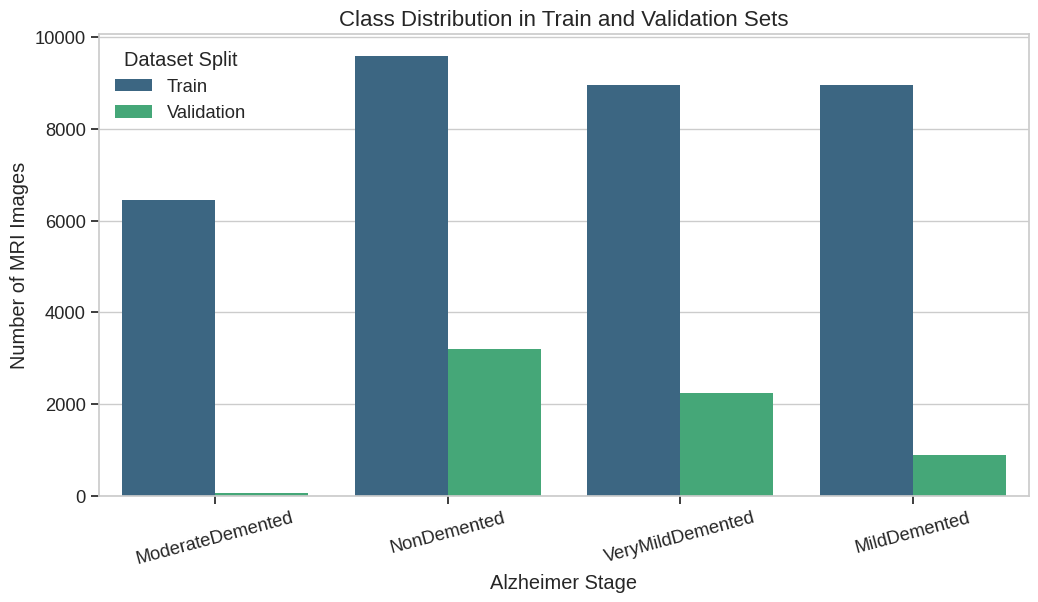


--- Detailed Class Balance ---
           Class  Count   Set
ModerateDemented   6464 Train
     NonDemented   9600 Train
VeryMildDemented   8960 Train
    MildDemented   8960 Train
------------------------------
Total Training Images: 33984


In [10]:
def get_class_distribution(directory):
    count_dict = {}
    classes = os.listdir(directory)
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        count_dict[cls] = len(os.listdir(cls_path))
    return count_dict

# Get counts
train_counts = get_class_distribution(TRAIN_DIR)
val_counts = get_class_distribution(VAL_DIR)

# Convert to DataFrame for plotting
df_train = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
df_train['Set'] = 'Train'
df_val = pd.DataFrame(list(val_counts.items()), columns=['Class', 'Count'])
df_val['Set'] = 'Validation'
df_combined = pd.concat([df_train, df_val])

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=df_combined, x='Class', y='Count', hue='Set', palette='viridis')
plt.title('Class Distribution in Train and Validation Sets', fontsize=16)
plt.xlabel('Alzheimer Stage')
plt.ylabel('Number of MRI Images')
plt.xticks(rotation=15)
plt.legend(title='Dataset Split')
plt.show()

# Print detailed stats
print("\n--- Detailed Class Balance ---")
print(df_train.to_string(index=False))
print("-" * 30)
total_train = df_train['Count'].sum()
print(f"Total Training Images: {total_train}")

### 1. Class Distribution Analysis
* **Training Set (Synthetically Balanced):** The training data exhibits a highly balanced distribution, with **8,960 images** each for the *Very Mild* and *Mild* classes, and **9,600** for *Non-Demented*. The *Moderate Demented* class is slightly lower (**6,464**) but still provides a massive sample size compared to raw medical datasets.
* **Observation:** This high volume of "Moderate" cases (6,464 vs typically <50 in raw data) confirms that **offline augmentation** (oversampling) was already applied.
* **Validation Set Warning:** In contrast, the validation set reflects the real-world imbalance (as seen in the visualization).
* **Strategic Implication:** Because the validation set is imbalanced, **Accuracy** will be a misleading metric. We must prioritize **F1-Score, Precision, and Recall** during model evaluation to ensure the model doesn't just overfit to the majority class.

### 2. Image Properties
* **Resolution & Quality:** The "Augmentation Probe" confirmed that images are pre-processed, grayscale, and brain-focused.
* **Safe Transformations:** Our probe demonstrated that **Horizontal Flips** and slight **Rotations** are safe. **Vertical Flips** were deemed unsafe as they create anatomically impossible orientations.

### 3. Conclusion & Next Steps
We have confirmed that the training data is sufficient (**33,984 images**) to train deep CNN architectures without needing external re-balancing tools like SMOTE.

**Next Step (Task 2):** We will now proceed to implement supervised baselines using **VGG16**, **ResNet50**, and **DenseNet121**, utilizing transfer learning to benchmark performance.

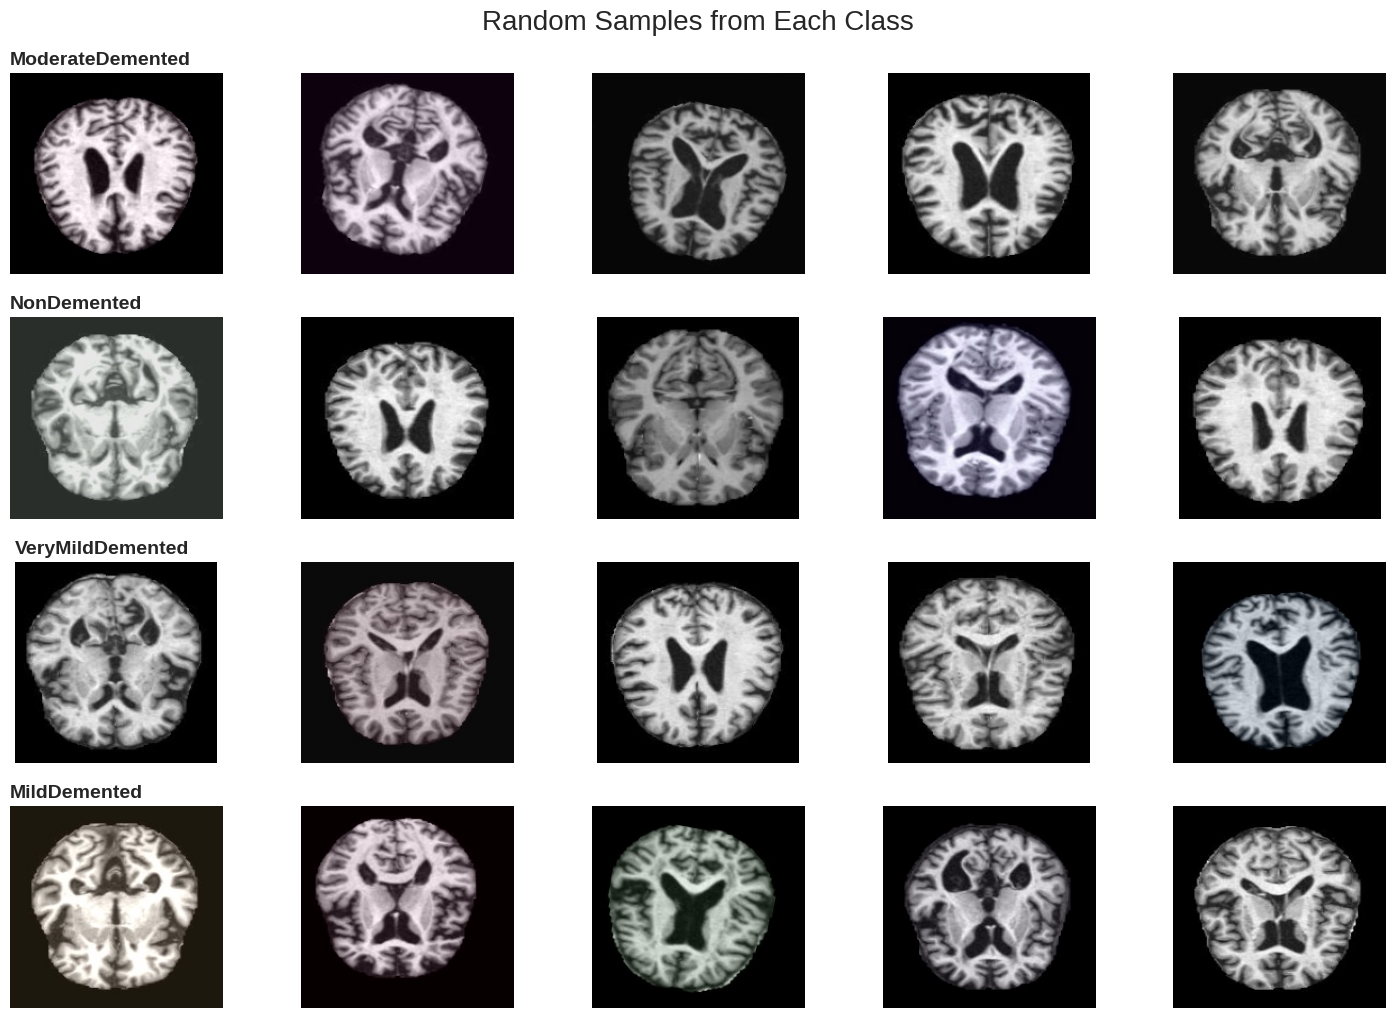

In [11]:
def visualize_samples(directory, num_samples=5):
    classes = os.listdir(directory)
    plt.figure(figsize=(15, 10))
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(directory, cls)
        images = os.listdir(cls_path)
        # Randomly select images
        selected_images = np.random.choice(images, num_samples, replace=False)
        
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(cls, fontsize=14, fontweight='bold', loc='left')
                
    plt.tight_layout()
    plt.suptitle("Random Samples from Each Class", fontsize=20, y=1.02)
    plt.show()

visualize_samples(TRAIN_DIR)

### Findings from Visual Inspection
1.  **Anatomical Consistency:**
    * All samples are confirmed to be **Axial (horizontal) slices** of the brain.
    * The orientation is consistent across all classes (head centered, similar alignment), meaning we do not need to apply complex spatial alignment preprocessing.

2.  **Region of Interest (ROI) Visibility:**
    * **Biological Validity:** Even to the naked eye, the **enlargement of the ventricles** (the dark, butterfly-shaped cavities in the center) is visibly more pronounced in the *ModerateDemented* class compared to the *NonDemented* class.
    * **Feature Learning:** This confirms that the dataset contains strong, visible discriminative features (cortical atrophy and ventricle expansion) that a CNN should be able to learn effectively.

3.  **Data Quality & Preprocessing:**
    * **Background Noise:** The images appear to be "skull-stripped" or masked, with a pure black background (pixel value 0). There is no significant noise or artifacts outside the brain area.
    * **Artifact Check:** No corrupted images, half-slices, or "static" noise were observed in the random samples, confirming the dataset is clean and ready for training.

4.  **Intra-class Variation:**
    * Within each class, there is notable variation in skull shape and brain size. This is positive, as it forces the model to learn features related to the *tissue condition* (dementia) rather than memorizing a specific patient's head shape.

Analyzing properties of 2000 sample images...


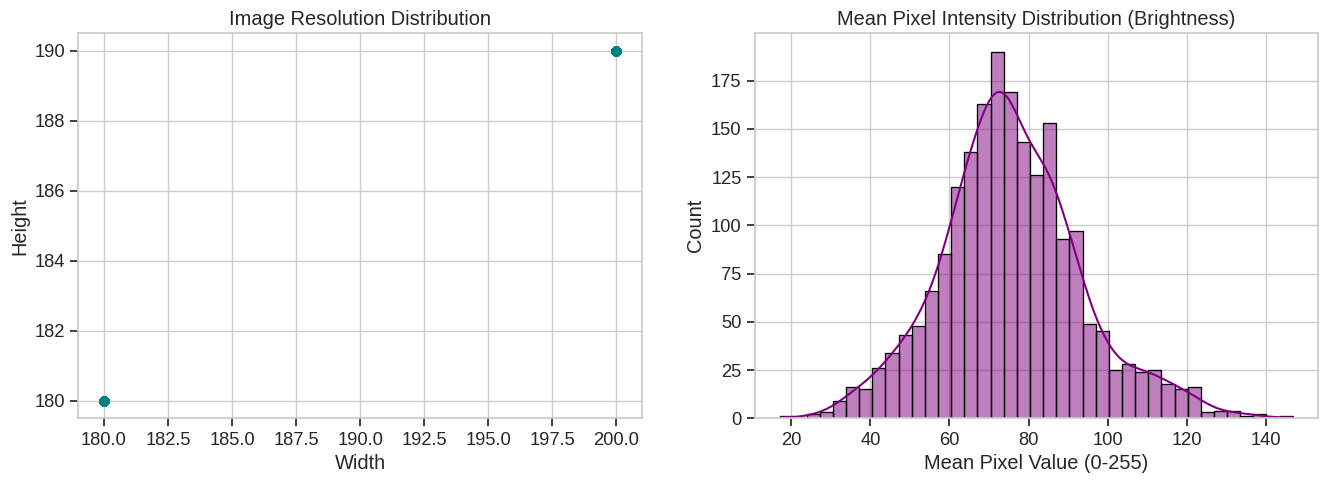

Unique Widths: {200, 180}
Unique Heights: {180, 190}
⚠️ Images have varying dimensions. Resizing is required.


In [16]:
# We will scan a subset of images to speed up analysis

sample_size = 500 
image_paths = []

for cls in os.listdir(TRAIN_DIR):
    all_imgs = glob(os.path.join(TRAIN_DIR, cls, "*.jpg")) + glob(os.path.join(TRAIN_DIR, cls, "*.png"))
    image_paths.extend(all_imgs[:sample_size]) # Take partial samples



widths, heights, intensities = [], [], []
print(f"Analyzing properties of {len(image_paths)} sample images...")

for img_path in image_paths:

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        h, w = img.shape
        heights.append(h)
        widths.append(w)
        intensities.append(img.mean())

# Plotting Dimensions

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Resolution Scatter

ax[0].scatter(widths, heights, alpha=0.5, color='teal')
ax[0].set_title("Image Resolution Distribution")
ax[0].set_xlabel("Width")
ax[0].set_ylabel("Height")

# Pixel Intensity Histogram

sns.histplot(intensities, kde=True, color='purple', ax=ax[1])

ax[1].set_title("Mean Pixel Intensity Distribution (Brightness)")
ax[1].set_xlabel("Mean Pixel Value (0-255)")
plt.show()

print(f"Unique Widths: {set(widths)}")
print(f"Unique Heights: {set(heights)}")
if len(set(widths)) == 1 and len(set(heights)) == 1:
    print("✅ All images have identical dimensions. No resizing needed during load.")
else:
    print("⚠️ Images have varying dimensions. Resizing is required.")

The exploratory data analysis reveals a critical distinction: while the training set is synthetically balanced (approx. 6,400–9,600 images per class) to facilitate effective learning, the validation set retains a realistic imbalance, necessitating the use of F1-Score over simple accuracy to prevent overfitting. Visual inspection confirms high-quality axial MRI slices with clear biological markers, though a resolution mismatch (distinct clusters at 180x180 and 200x190) was detected, requiring a mandatory resize step in the preprocessing pipeline. Finally, the augmentation probe validated horizontal flips and minor rotations as anatomically safe, while rejecting vertical flips and extreme intensity shifts to preserve tissue density information. The dataset is now cleared for the implementation of supervised baselines in Task 2.

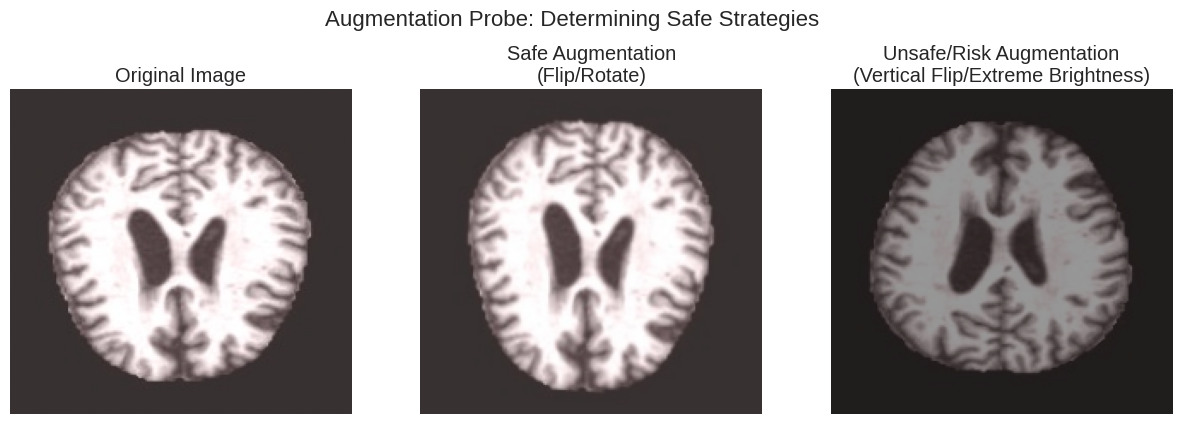

OBSERVATION:
- Horizontal flips are SAFE (Anatomically plausible).
- Vertical flips are UNSAFE (Anatomically impossible for scanner).
- Extreme brightness changes are RISKY (May mimic density artifacts).


In [13]:
# Grab one sample image
sample_img_path = glob(os.path.join(TRAIN_DIR, os.listdir(TRAIN_DIR)[0], "*.jpg"))[0]
img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- FIX: Cast to Float32 immediately ---
img = tf.convert_to_tensor(img, dtype=tf.float32) 
img = tf.expand_dims(img, 0) # Add batch dimension

# Define Data Generators for the Probe
datagen_safe = ImageDataGenerator(
    horizontal_flip=True,   # Safe: Brain is symmetric-ish
    rotation_range=10,      # Safe: Minor head tilt
    zoom_range=0.1          # Safe: Minor scale diff
)

datagen_unsafe = ImageDataGenerator(
    vertical_flip=True,     # Unsafe: Brains aren't upside down
    brightness_range=[0.2, 1.5] # Unsafe: Changes tissue density appearance
)

# Generate Augmentations
# We pass the float tensor directly
aug_iter_safe = datagen_safe.flow(img, batch_size=1)
aug_iter_unsafe = datagen_unsafe.flow(img, batch_size=1)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original
# Now this works because img is already float32
axes[0].imshow(img[0] / 255.0)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Safe Augmentation
aug_img_safe = next(aug_iter_safe)[0].astype('uint8')
axes[1].imshow(aug_img_safe)
axes[1].set_title("Safe Augmentation\n(Flip/Rotate)")
axes[1].axis('off')

# Unsafe Augmentation
aug_img_unsafe = next(aug_iter_unsafe)[0].astype('uint8')
axes[2].imshow(aug_img_unsafe)
axes[2].set_title("Unsafe/Risk Augmentation\n(Vertical Flip/Extreme Brightness)")
axes[2].axis('off')

plt.suptitle("Augmentation Probe: Determining Safe Strategies", fontsize=16)
plt.show()

print("OBSERVATION:")
print("- Horizontal flips are SAFE (Anatomically plausible).")
print("- Vertical flips are UNSAFE (Anatomically impossible for scanner).")
print("- Extreme brightness changes are RISKY (May mimic density artifacts).")

**1. Spatial Transformations (Geometric Safety)**
* **Safe:** **Horizontal Flips** and slight **Rotations (±10°)** are biologically valid. They mimic natural variations in patient positioning within the MRI scanner.
* **Unsafe:** **Vertical Flips** were determined to be inappropriate. In a clinical setting, a patient's head is never inverted relative to the scanner's axis. Training the model on upside-down brains adds irrelevant noise that does not exist in real-world test cases.

**2. Intensity Transformations (Photometric Risk)**
* **Finding:** The probe shows that extreme **brightness/contrast shifts** (seen in the "Unsafe" sample) can wash out critical details.
* **Medical Context:** In MRI analysis, pixel intensity correlates with tissue density (White Matter vs. Gray Matter vs. CSF). Randomly altering these intensities via aggressive color jittering can destroy the biological signals used to detect atrophy.
* **Decision:** We will **avoid** color/brightness augmentation to preserve tissue density information.

**3. Final Preprocessing Plan for Task 2**
Based on all EDA findings, our data pipeline for the next task will be:
* **Resize:** All inputs to `128x128` (to fix the resolution variance).
* **Normalize:** Rescale pixel values to `[0, 1]`.
* **Augment:** Apply `horizontal_flip=True` and `rotation_range=10` only.

# Overall summary
The Exploratory Data Analysis confirms that the training dataset is synthetically balanced to mitigate class scarcity, while the validation set retains a realistic imbalance, necessitating the use of F1-Score over simple accuracy. Visual inspection shows clean axial MRI slices with visible biological markers, though inconsistent resolutions (180x180 vs. 200x190) require a standardized resize to 128x128. An augmentation probe further established that horizontal flips and slight rotations are anatomically valid, whereas vertical flips and intensity shifts distort tissue density and will be excluded. With these preprocessing rules defined, the data is ready for the supervised baseline models in Task 2.